In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from matplotlib import pyplot as plt
import requests
import pprint
from enum import Enum
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


Using TensorFlow backend.
/home/howardwang15/Documents/fut-ratings-predictions/src/server/fut-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/howardwang15/Documents/fut-ratings-predictions/src/server/fut-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/howardwang15/Documents/fut-ratings-predictions/src/server/fut-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be u

In [2]:
pp = pprint.PrettyPrinter(indent=2)

In [3]:

class Attributes(Enum):
    PACE = 'pace'
    SHOT = 'shot'
    PASS = 'pass'
    DRIBBLE = 'dribble'
    DEFENSE = 'defense'
    PHYSICAL = 'physical'
    
class Positions(Enum):
    ATTACKER = 0
    LEFT_WING = 1
    RIGHT_WING = 2
    CENTER_MID = 3
    DEFENSIVE_MID = 4
    CENTER_BACK = 5
    FULL_BACK = 6

n_pages = 180

In [4]:
data = []
for i in range(1, n_pages):
    response = requests.get('https://www.easports.com/fifa/ultimate-team/api/fut/item?page={}'.format(i))
    json = response.json()
    data.append(json)

items = [item['items'] for item in data]
items = [item for sublist in items for item in sublist]

In [25]:
players = []
for item in items:
    player = dict()
    if not item['commonName']:
        player.update({'name': item['firstName'] + ' ' + item['lastName']})
    else:
        player.update({'name': item['commonName']})

    all_attributes = []
    for attribute in item['attributes']:
        attributes = dict()
        attribute_name = attribute['name']
        attribute_value = attribute['value']
        attributes['value'] = attribute_value
        if attribute_name == 'fut.attribute.PAC':
            attributes['name'] = Attributes.PACE.name
        elif attribute_name == 'fut.attribute.SHO':
            attributes['name'] = Attributes.SHOT.name
        elif attribute_name == 'fut.attribute.PAS':
            attributes['name'] = Attributes.PASS.name
        elif attribute_name == 'fut.attribute.DRI':
            attributes['name'] = Attributes.DRIBBLE.name
        elif attribute_name == 'fut.attribute.DEF':
            attributes['name'] = Attributes.DEFENSE.name
        elif attribute_name == 'fut.attribute.PHY':
            attributes['name'] = Attributes.PHYSICAL.name
        all_attributes.append(attributes)
    
    player['attributes'] = all_attributes
    player['rating'] = item['rating']
    if item['position'] == 'ST' or item['position'] == 'CF':
        player['position'] = Positions.ATTACKER.value
    elif item['position'] == 'LW' or item['position'] == 'LM' or item['position'] == 'LF':
        player['position'] = Positions.LEFT_WING.value
    elif item['position'] == 'RW' or item['position'] == 'RM' or item['position'] == 'RF':
        player['position'] = Positions.RIGHT_WING.value
    elif item['position'] == 'CM' or item['position'] == 'CAM':
        player['position'] = Positions.CENTER_MID.value
    elif item['position'] == 'CDM':
        player['position'] = Positions.DEFENSIVE_MID.value
    elif item['position'] == 'CB':
        player['position'] = Positions.CENTER_BACK.value
    elif item['position'] == 'LB' or item['position'] == 'RB' or item['position'] == 'LWB' or item['position'] == 'RWB':
        player['position'] = Positions.FULL_BACK.value
    elif item['position'] == 'GK':
        player['position'] = Positions.KEEPER.value
        continue
    player['position'] = keras.utils.to_categorical(player['position'], num_classes=7)
    players.append(player)
            

    

In [32]:
player_data = []
labels = []
for i in range(len(players)):
    data = []
    for attribute in players[i]['attributes']:
        data.append(attribute['value'])
    inputs = (data, players[i].get('position'), players[i]['name'])
    player_data.append(inputs)
    labels.append(players[i]['rating'])
    
labels = np.asarray(labels)
training_x, testing_x, training_y, testing_y = train_test_split(player_data, labels, test_size=0.25, random_state=42)


In [33]:
training_input_attributes = [d[0] for d in training_x]
training_input_position = [d[1] for d in training_x]
training_names = [d[2] for d in training_x]
testing_input_attributes = [d[0] for d in testing_x]
testing_input_position = [d[1] for d in testing_x]
testing_names = [d[2] for d in testing_x]

In [8]:
def plot_loss(loss):
    epochs = [i for i, _ in enumerate(loss)]
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.plot(epochs, loss)
    plt.show()

In [49]:
input_position = keras.layers.Input(shape=(7,))
dense_position = keras.layers.Dense(units=16, activation='relu')(input_position)
# dense_position = keras.layers.Dense(units=8, activation='relu')(dense_position)

input_attributes = keras.layers.Input(shape=(6,))
dense_attributes = keras.layers.Dense(units=32, activation='relu')(input_attributes)
# dense_attributes = keras.layers.Dense(units=32, activation='relu')(dense_attributes)

# dense_attributes = keras.layers.Dense(units=8, activation='relu')(dense_attributes)

concat_player = keras.layers.concatenate([dense_position, dense_attributes])
prediction = keras.layers.Dense(units=1)(concat_player)
model = keras.models.Model(inputs=[input_position, input_attributes], outputs=prediction)

model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.001))
history = model.fit([training_input_position, training_input_attributes], training_y, epochs=60, batch_size=4)


Epoch 1/60
2933/2933 [==============================] - 1s 391us/step - loss: 189.3003
Epoch 2/60
2933/2933 [==============================] - 1s 285us/step - loss: 11.6033
Epoch 3/60
2933/2933 [==============================] - 1s 281us/step - loss: 8.6212
Epoch 4/60
2933/2933 [==============================] - 1s 273us/step - loss: 7.0852
Epoch 5/60
2933/2933 [==============================] - 1s 272us/step - loss: 6.2894
Epoch 6/60
2933/2933 [==============================] - 1s 273us/step - loss: 5.8916
Epoch 7/60
2933/2933 [==============================] - 1s 274us/step - loss: 5.7842
Epoch 8/60
2933/2933 [==============================] - 1s 285us/step - loss: 5.5052
Epoch 9/60
2933/2933 [==============================] - 1s 288us/step - loss: 5.4881
Epoch 10/60
2933/2933 [==============================] - 1s 275us/step - loss: 5.1257
Epoch 11/60
2933/2933 [==============================] - 1s 278us/step - loss: 5.1529
Epoch 12/60
2933/2933 [==============================] - 1s 

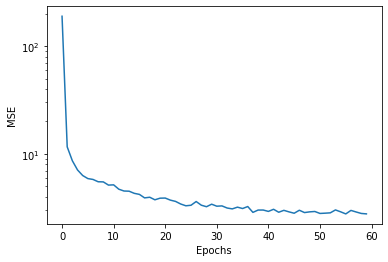

In [50]:
plot_loss(history.history['loss'])

In [51]:
def predict(model, index):
    attributes, position, name = testing_x[index]
    rating = model.predict([np.expand_dims(position, axis=0), np.expand_dims(np.array(attributes), axis=0)])
    position = np.where(position==1)[0]
    if position == 0:
        position = 'ATTACKER'
    elif position == 1:
        position = 'LEFT WING'
    elif position == 2:
        position = 'RIGHT WING'
    elif position == 3:
        position = 'CENTER MID'
    elif position == 4:
        position = 'CENTER DEFENSIVE MID'
    elif position == 5:
        position = 'CENTER BACK'
    elif position == 6:
        position = 'FULL BACK'
    
    prediction = {
        'name': name,
        'attributes': attributes,
        'position': position,
        'rating': round(rating[0][0]),
        'actual label': testing_y[index]
    }
    return prediction
    

In [52]:
for i in range(25):
    pp.pprint(predict(model, i))

{ 'actual label': 86,
  'attributes': [77, 88, 79, 81, 48, 87],
  'name': 'André-Pierre Gignac',
  'position': 'ATTACKER',
  'rating': 87.0}
{ 'actual label': 84,
  'attributes': [84, 56, 79, 82, 82, 77],
  'name': 'Ben Chilwell',
  'position': 'FULL BACK',
  'rating': 85.0}
{ 'actual label': 84,
  'attributes': [71, 60, 70, 69, 83, 84],
  'name': 'Matthijs de Ligt',
  'position': 'CENTER BACK',
  'rating': 85.0}
{ 'actual label': 78,
  'attributes': [85, 53, 69, 75, 74, 77],
  'name': 'Santiago Arias',
  'position': 'FULL BACK',
  'rating': 78.0}
{ 'actual label': 86,
  'attributes': [70, 87, 78, 80, 35, 80],
  'name': 'Zlatan Ibrahimović',
  'position': 'ATTACKER',
  'rating': 86.0}
{ 'actual label': 87,
  'attributes': [71, 83, 83, 85, 81, 86],
  'name': 'Sergej Milinković-Savić',
  'position': 'CENTER MID',
  'rating': 88.0}
{ 'actual label': 94,
  'attributes': [88, 92, 96, 93, 55, 72],
  'name': 'Pablo Sarabia',
  'position': 'CENTER MID',
  'rating': 94.0}
{ 'actual label': 87,


In [53]:
model.save('fut.h5')